<font size=6><b> House Prices - Advanced Regression Techniques
* ref: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/leaderboard

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

sns.set() 
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'  # 한글 처리
plt.rcParams['axes.unicode_minus'] = False  # -, $ 등등에 표현 특수기호로 버리지 말고 다 써줘라.

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import HuberRegressor, BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import NuSVR

# Data Load

In [66]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Drop ID

In [67]:
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

# 결측처리

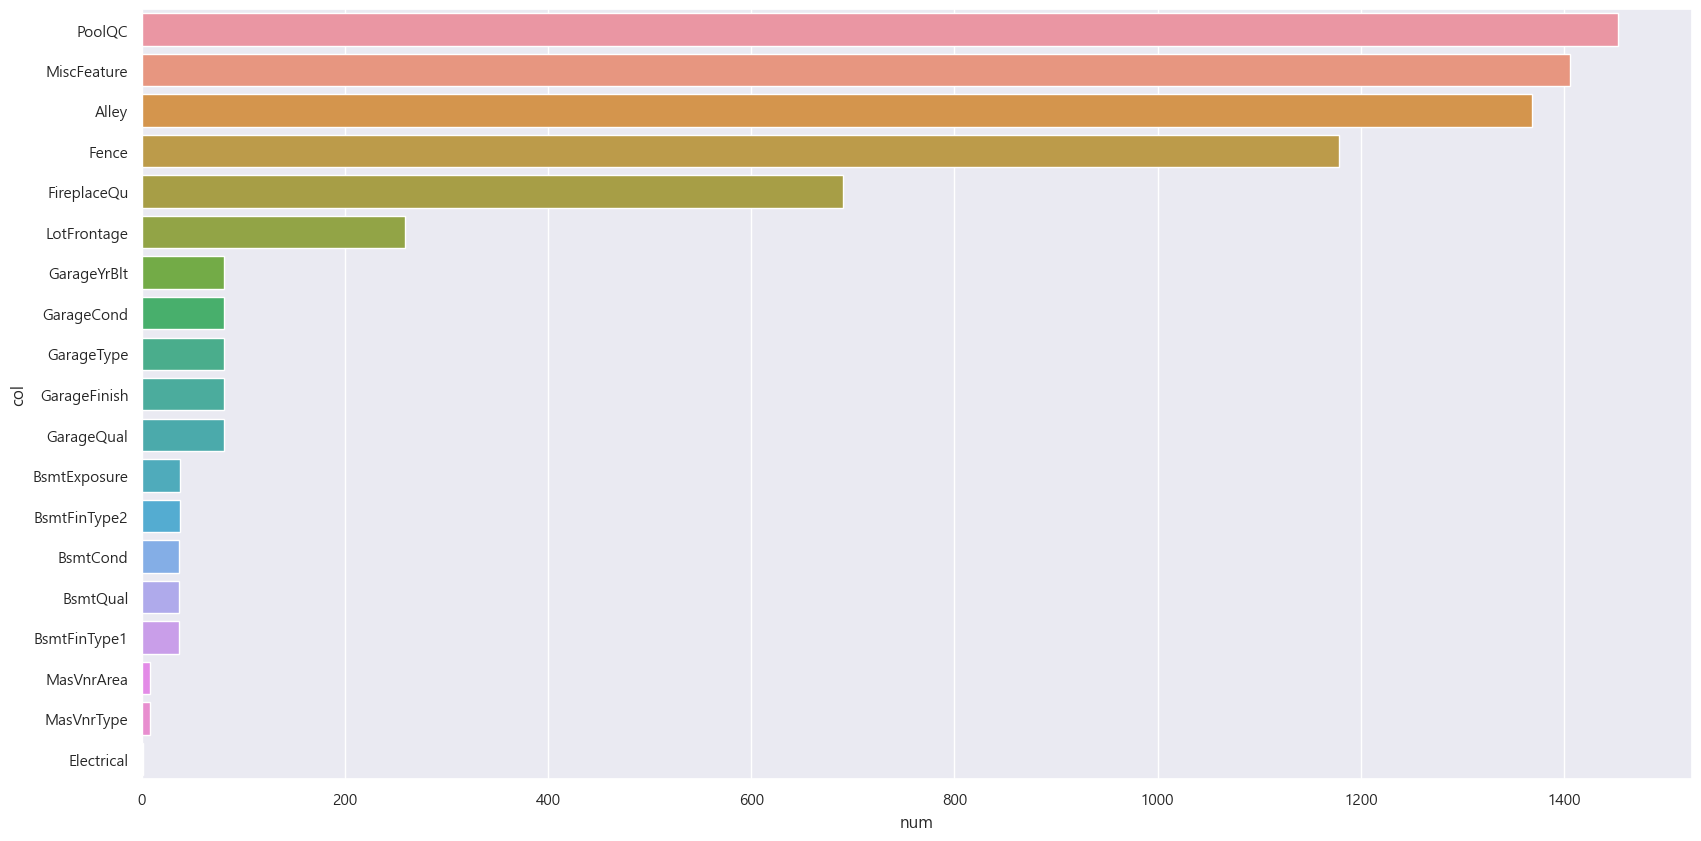

In [68]:
# 컬럼별, 결측 값 개수 확인
col_list = train.columns
na_list = []
for col in col_list:
    na_list.append([col, train[train[col].isna()].shape[0]])
    
nadf = pd.DataFrame(na_list, columns=['col','num']).sort_values(by='num', ascending=False)
nadf = nadf[nadf['num']!=0]
plt.figure(figsize=(20, 10))
sns.barplot(nadf, y='col', x='num')
plt.show()

In [69]:
# 이상치가 많은 4개 Feature : PoolQC, MiscFeature, Alley, Fence

# PoolQC, imbalance Data
train['isPool'] = 0
train['isPool'] = np.where(train['PoolArea']!=0, 1, 0)
test['isPool'] = 0
test['isPool'] = np.where(test['PoolArea']!=0, 1, 0)

# MiscFeature, imbalance Data
train['isShed'] = 0
train['isShed'] = np.where(train['MiscFeature']=='Shed', 1, 0)
test['isShed'] = 0
test['isShed'] = np.where(test['MiscFeature']=='Shed', 1, 0)

# Fence, imbalance Data
train['isFence'] = 0
train['isFence'] = np.where(train['Fence'].isna(), 0, 1)
test['isFence'] = 0
test['isFence'] = np.where(test['Fence'].isna(), 0, 1)

# Alley, 결측이 많고 다른 Feature들과 다중공선, 컬럼 삭제
train = train.drop(['PoolArea','PoolQC', 'MiscFeature', 'Fence', 'Alley'], axis=1)
test = test.drop(['PoolArea','PoolQC', 'MiscFeature', 'Fence', 'Alley'], axis=1)

In [70]:
# None 및 최빈값 처리
col_list = [('GarageQual', 'GarageType'), ('GarageCond', 'GarageType'),
            ('GarageFinish', 'GarageType'), ('MasVnrType', 'MasVnrArea')]

for col1, col2 in col_list:
    nan_idx = train[(train[col1].isna())&(train[col2].notna())].index.values
    mode_v = train[col1].mode().values[0]
    train.loc[nan_idx, col1] = mode_v
    train[col1] = train[col1].fillna('None')
    
    nan_idx =test[(test[col1].isna())&(test[col2].notna())].index.values
    mode_v = test[col1].mode().values[0]
    test.loc[nan_idx, col1] = mode_v
    test[col1] = test[col1].fillna('None')
    
# None 처리
col_list = ['FireplaceQu', 'BsmtQual', 'BsmtExposure',  'MasVnrType', 'GarageType']
for col in col_list:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

# 0 처리
col_list = ['LotFrontage', 'MasVnrArea']
for col in col_list: 
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

# 최빈값 처리, 'Electrical'
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode().values[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode().values[0])

# BsmtCond,  TotalBsmtSF
train['BsmtCond'] = train['BsmtCond'].fillna('None')

test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
nan_idx = test[(test['BsmtCond'].isna())&(test['TotalBsmtSF']!=0)].index.values
mode_v = test['BsmtCond'].mode()
test.loc[nan_idx, 'BsmtCond'] = mode_v.values[0]
test['BsmtCond'] = test['BsmtCond'].fillna('None')

# GarageYrBlt: YearBuilt로 결측처리
garageNa_idx = train[train['GarageYrBlt'].isna()].index.values
train.loc[garageNa_idx, 'GarageYrBlt'] = train.loc[garageNa_idx, 'YearBuilt']

garageNa_idx = test[test['GarageYrBlt'].isna()].index.values
test.loc[garageNa_idx, 'GarageYrBlt'] = test.loc[garageNa_idx, 'YearBuilt']

# train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
# test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

In [71]:
# 두개 합쳐서 Onehot encoding 'BsmtFinType1',  'BsmtFinType2'
dum1 = pd.get_dummies(train['BsmtFinType1'])
dum2 = pd.get_dummies(train['BsmtFinType2'])
dum = dum1|dum2
dum = dum.rename(columns = {'ALQ':'BsmtALQ','BLQ':'BsmtBLQ',
                            'BLQ':'BsmtBLQ', 'LwQ':'BsmtLwQ', 
                            'Rec':'BsmtRec', 'Unf':'BsmtUnf'})
train = pd.concat([train, dum], axis=1)
train = train.drop(['BsmtFinType1','BsmtFinType2'], axis=1)

dum1 = pd.get_dummies(test['BsmtFinType1'])
dum2 = pd.get_dummies(test['BsmtFinType2'])
dum = dum1|dum2
dum = dum.rename(columns = {'ALQ':'BsmtALQ','BLQ':'BsmtBLQ',
                            'BLQ':'BsmtBLQ', 'LwQ':'BsmtLwQ', 
                            'Rec':'BsmtRec', 'Unf':'BsmtUnf'})
test = pd.concat([test, dum], axis=1)
test = test.drop(['BsmtFinType1','BsmtFinType2'], axis=1)

In [72]:
# 추가 결측 처리

# 수치형 데이터, 평균값 처리
col_list = ['BsmtFullBath', 'BsmtHalfBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1', 
            'GarageCars', 'GarageArea', 'TotalBsmtSF']
for col in col_list:
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(test[col].mean())
    
# 이산형 데이터, mode값 처리
col_list = ['MSZoning', 'Functional', 'Utilities','SaleType', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'BedroomAbvGr']
for col in col_list:
    train[col] = train[col].fillna(train[col].mode().values[0])
    test[col] = test[col].fillna(test[col].mode().values[0])

# Object 처리

In [73]:
## Qual, Con Label처리 (12개 컬럼)
col_list = ['KitchenQual','HeatingQC','FireplaceQu', 'ExterQual', 
            'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
           'HeatingQC', 'ExterQual', 'ExterCond']

for col in col_list:
    train[col] = train[col].replace(['Ex','Gd','TA','Fa','Po','None'],
                                    [5, 4, 3, 2, 1, 0])
    test[col] = test[col].replace(['Ex','Gd','TA','Fa','Po','None'],
                                    [5, 4, 3, 2, 1, 0])

train['LandSlope'] = train['LandSlope'].replace(['Gtl','Mod','Sev'],[1, 2, 3])
test['LandSlope'] = test['LandSlope'].replace(['Gtl','Mod','Sev'],[1, 2, 3])

train['BsmtExposure'] = train['BsmtExposure'].replace(['Gd','Av','Mn','No','None'],
                                                      [4, 3, 2, 1, 0])
test['BsmtExposure'] = test['BsmtExposure'].replace(['Gd','Av','Mn','No','None'],
                                                      [4, 3, 2, 1, 0])

train['PavedDrive'] = train['PavedDrive'].replace(['Y','P','N', 'None'],[3, 2, 1, 0])
test['PavedDrive'] = test['PavedDrive'].replace(['Y','P','N', 'None'],[3, 2, 1, 0])

train['LotShape'] = train['LotShape'].replace(['Reg','IR1','IR2','IR3'], [0, 1, 2, 3])
test['LotShape'] = test['LotShape'].replace(['Reg','IR1','IR2','IR3'], [0, 1, 2, 3])


train['Functional'] = train['Functional'].replace(['Min1','Min2','Mod','Maj1', 'Maj2', 'Sev','Sal'], 
                                                [7, 6, 5, 4, 3, 2, 1])
test['Functional'] = test['Functional'].replace(['Min1','Min2','Mod','Maj1', 'Maj2', 'Sev','Sal'], 
                                                [7, 6, 5, 4, 3, 2, 1])

In [74]:
# Condition1,  Condition1
oh = OneHotEncoder(sparse=False)
oh.fit(train['Condition1'].values.reshape(-1, 1))

dum1 = oh.transform(train['Condition1'].values.reshape(-1, 1))
dum2 = oh.transform(train['Condition2'].values.reshape(-1, 1))

dum1 = dum1.astype(int)
dum2 = dum2.astype(int)

dum = dum1|dum2

dumdf = pd.DataFrame(dum, columns= ['ConNorm', 'ConFeedr', 'ConPosN', 'ConArtery', 
                            'ConRRAe', 'ConRRNn', 'ConRRAn', 'ConPosA','ConRRNe'])

train = pd.concat([train, dumdf], axis=1)
train = train.drop(['Condition1','Condition2'], axis=1)

dum1 = oh.transform(test['Condition1'].values.reshape(-1, 1))
dum2 = oh.transform(test['Condition2'].values.reshape(-1, 1))

dum1 = dum1.astype(int)
dum2 = dum2.astype(int)

dum = dum1|dum2

dumdf = pd.DataFrame(dum, columns= ['ConNorm', 'ConFeedr', 'ConPosN', 'ConArtery', 
                            'ConRRAe', 'ConRRNn', 'ConRRAn', 'ConPosA','ConRRNe'])

test = pd.concat([test, dumdf], axis=1)
test = test.drop(['Condition1','Condition2'], axis=1)


In [75]:
# Exterior1st, Exterior2nd
# 주요 카테고리 
# 'VinylSd', 'MetalSd' ('Wd Sdng', 'WdShing'), 'HdBoard', 'Plywood' and 'Other'
train['Exterior1st'] = train['Exterior1st'].replace('Wd Sdng', 'WdShing')
cidx = train[(train['Exterior1st']!= 'VinylSd')&(train['Exterior1st']!= 'MetalSd')&
        (train['Exterior1st']!= 'WdShing')&(train['Exterior1st']!= 'HdBoard')&
        (train['Exterior1st']!= 'Plywood')].index.values
train.loc[cidx, 'Exterior1st'] = 'Other'

test['Exterior1st'] = test['Exterior1st'].replace('Wd Sdng', 'WdShing')
cidx = test[(test['Exterior1st']!= 'VinylSd')&(test['Exterior1st']!= 'MetalSd')&
        (test['Exterior1st']!= 'WdShing')&(test['Exterior1st']!= 'HdBoard')&
        (test['Exterior1st']!= 'Plywood')].index.values
test.loc[cidx, 'Exterior1st'] = 'Other'

train['Exterior2nd'] = train['Exterior2nd'].replace('Wd Sdng', 'WdShing')
cidx = train[(train['Exterior2nd']!= 'VinylSd')&(train['Exterior2nd']!= 'MetalSd')&
        (train['Exterior2nd']!= 'WdShing')&(train['Exterior2nd']!= 'HdBoard')&
        (train['Exterior2nd']!= 'Plywood')].index.values
train.loc[cidx, 'Exterior2nd'] = 'Other'

test['Exterior2nd'] = test['Exterior2nd'].replace('Wd Sdng', 'WdShing')
cidx = test[(test['Exterior2nd']!= 'VinylSd')&(test['Exterior2nd']!= 'MetalSd')&
        (test['Exterior2nd']!= 'WdShing')&(test['Exterior2nd']!= 'HdBoard')&
        (test['Exterior2nd']!= 'Plywood')].index.values
test.loc[cidx, 'Exterior2nd'] = 'Other'


dum1 = pd.get_dummies(train['Exterior1st'])
dum2 = pd.get_dummies(train['Exterior2nd'])
dum = dum1|dum2
dum = dum.rename(columns = {'VinylSd':'ExtVinylSd','MetalSd':'ExtMetalSd',
                            'HdBoard':'ExtHdBoard', 'Plywood':'ExtPlywood', 
                            'WdShing':'ExtWdShing', 'Other':'ExtOther'})
train = pd.concat([train, dum], axis=1)
train = train.drop(['Exterior1st','Exterior2nd'], axis=1)

dum1 = pd.get_dummies(test['Exterior1st'])
dum2 = pd.get_dummies(test['Exterior2nd'])
dum = dum1|dum2
dum = dum.rename(columns = {'VinylSd':'ExtVinylSd','MetalSd':'ExtMetalSd',
                            'HdBoard':'ExtHdBoard', 'Plywood':'ExtPlywood', 
                            'WdShing':'ExtWdShing', 'Other':'ExtOther'})
test = pd.concat([test, dum], axis=1)
test = test.drop(['Exterior1st','Exterior2nd'], axis=1)

In [76]:
# MSZoning
train['wPark'] = 0
pidx = train[train['MSZoning']=='RP'].index.values
train.loc[pidx, 'wPark'] = 1
train.loc[pidx, 'MSZoning'] = 'RL'

test['wPark'] = 0
pidx = test[test['MSZoning']=='RP'].index.values
test.loc[pidx, 'wPark'] = 1
test.loc[pidx, 'MSZoning'] = 'RL'

In [77]:
# Utilities
# AllPub와 NoSeWa(1건)으로 구성됨.
# But test data에는 AllPub 밖에 없음.
# Train에서 NoSeWa(1건) drop하고 컬럼 삭제
didx = train[train['Utilities']=='NoSeWa'].index.values
train = train.drop(didx, axis=0)

train = train.drop('Utilities', axis=1)
test = test.drop('Utilities', axis=1)

In [78]:
# 'Electrical'
# SBrkr, FuseABC, Mix(1건)인데, test에는 Mix가 없음
# Mix(1건) drop
didx = train[train['Electrical']=='Mix'].index.values
train = train.drop(didx, axis=0)

In [79]:
train['CentralAir'] = train['CentralAir'].replace(['Y', 'N'], [1, 0])
test['CentralAir'] = test['CentralAir'].replace(['Y', 'N'], [1, 0])

In [80]:
# 카테고리별 불균형한 데이터들, Others로 묶었으나, 정보의 손실이 발생해서 오히려 성능이 떨어짐
# Street Imbalance  
# train['Street'] = train['Street'].replace(['Pave', 'Grvl'], [1, 0])
# test['Street'] = test['Street'].replace(['Pave', 'Grvl'], [1, 0])

# # RoofMatl Imbalance
# cidx = train[(train['RoofMatl']=='CompShg')].index.values
# train.loc[cidx, 'RoofMatl'] = 1
# cidx = train[(train['RoofMatl']!=1)].index.values
# train.loc[cidx, 'RoofMatl'] = 0
# train['RoofMatl'] = train['RoofMatl'].astype('int')

# cidx = test[(test['RoofMatl']=='CompShg')].index.values
# test.loc[cidx, 'RoofMatl'] = 1
# cidx = test[(test['RoofMatl']!=1)].index.values
# test.loc[cidx, 'RoofMatl'] = 0
# test['RoofMatl'] = test['RoofMatl'].astype('int')

# # Heating Imbalance
# cidx = train[(train['Heating']=='GasA')].index.values
# train.loc[cidx, 'Heating'] = 1
# cidx = train[(train['Heating']!=1)].index.values
# train.loc[cidx, 'Heating'] = 0
# train['Heating'] = train['Heating'].astype('int')

# cidx = test[(test['Heating']=='GasA')].index.values
# test.loc[cidx, 'Heating'] = 1
# cidx = test[(test['Heating']!=1)].index.values
# test.loc[cidx, 'Heating'] = 0
# test['Heating'] = test['Heating'].astype('int')

In [81]:
# Imbalance Data 처리
# cidx = train[(train['RoofStyle']!='Gable')&(train['RoofStyle']!='Hip')].index.values
# train.loc[cidx, 'RoofStyle'] = 'RoofOther'
# cidx = test[(test['RoofStyle']!='Gable')&(test['RoofStyle']!='Hip')].index.values
# test.loc[cidx, 'RoofStyle'] = 'RoofOther'

# cidx = train[(train['Foundation']=='Slab')|(train['Foundation']=='Stone')|(train['Foundation']=='Wood')].index.values
# train.loc[cidx, 'Foundation'] = 'FoundOther'
# cidx = test[(test['Foundation']=='Slab')|(test['Foundation']=='Stone')|(test['Foundation']=='Wood')].index.values
# test.loc[cidx, 'Foundation'] = 'FoundOther'

# cidx = train[(train['Foundation']=='Slab')|(train['Foundation']=='Stone')|(train['Foundation']=='Wood')].index.values
# train.loc[cidx, 'Foundation'] = 'FoundOther'
# cidx = test[(test['Foundation']=='Slab')|(test['Foundation']=='Stone')|(test['Foundation']=='Wood')].index.values
# test.loc[cidx, 'Foundation'] = 'FoundOther'

# cidx = train[(train['GarageType']!='Attchd')&(train['GarageType']!='Detchd')
#              &(train['GarageType']!='BuiltIn')&(train['GarageType']!='None')].index.values
# train.loc[cidx, 'GarageType'] = 'GarageOther'

# cidx = test[(test['GarageType']!='Attchd')&(test['GarageType']!='Detchd')
#              &(test['GarageType']!='BuiltIn')&(test['GarageType']!='None')].index.values
# test.loc[cidx, 'GarageType'] = 'GarageOther'

In [82]:
# get_dummies 처리
lentrain = train.shape[0]
col_list = ['MSZoning', 'LandContour', 'LotConfig', 'RoofStyle', 'MasVnrType', 
            'Foundation', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition', 'BldgType', 'HouseStyle',
           'MoSold', 'YrSold']
totdf = pd.concat([train, test], axis=0)
# totdf = pd.get_dummies(totdf, columns=col_list)
totdf = pd.get_dummies(totdf)
train = totdf[:lentrain]
test = totdf[lentrain:]

# Featue Engineering

## 유사 컬럼 확인

In [83]:
print(train.columns[train.columns.str.contains("Bath", case=False)].values) # case는 대소문자 구분안하고 찾아주겠다.
print(train.columns[train.columns.str.contains("Bsmt", case=False)].values)
print(train.columns[train.columns.str.contains("Garage", case=False)].values) 

['BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath']
['BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' 'BsmtFullBath' 'BsmtHalfBath' 'BsmtALQ'
 'BsmtBLQ' 'BsmtLwQ' 'BsmtRec' 'BsmtUnf']
['GarageYrBlt' 'GarageCars' 'GarageArea' 'GarageQual' 'GarageCond'
 'GarageType_2Types' 'GarageType_Attchd' 'GarageType_Basment'
 'GarageType_BuiltIn' 'GarageType_CarPort' 'GarageType_Detchd'
 'GarageType_None' 'GarageFinish_Fin' 'GarageFinish_None'
 'GarageFinish_RFn' 'GarageFinish_Unf']


## 부지 정보
* 'Street','LotShape', 'LandSlope' : 영향도 적음. 삭제
* YearBuilt, YearRemodAdd : 주요 Feauture 파생변수 생성 필요
* OverallQual : 주요 Feature
* OverallCond: OverallQual와 음의 상관관계

In [84]:
# 영향이 적은 Feature 삭제

# col_list = ['Street','LotShape', 'LandSlope']
# train = train.drop(col_list, axis=1)
# test = test.drop(col_list, axis=1)

In [85]:
# cidx = train[train['MSZoning_RL'] ==1 ].index.values
# train.loc[cidx, 'MSZoning_RM'] = 1

# cidx = test[test['MSZoning_RL'] ==1].index.values
# test.loc[cidx, 'MSZoning_RM'] = 1

# droplist = ['MSZoning_RH', 'MSZoning_RL', 
# 'LandContour_Bnk','LandContour_Low','LandContour_Lvl','LotConfig_Corner','LotConfig_CulDSac','LotConfig_FR2','LotConfig_FR3','LotConfig_Inside',
# 'SaleCondition_AdjLand','SaleCondition_Alloca','SaleCondition_Family',
# 'BldgType_2fmCon','BldgType_Duplex','BldgType_TwnhsE',
# 'HouseStyle_1.5Unf','HouseStyle_1Story','HouseStyle_2.5Fin','HouseStyle_2.5Unf','HouseStyle_SFoyer','HouseStyle_SLvl']

# train = train.drop(droplist, axis=1)
# test = test.drop(droplist, axis=1)

## 주거지 구성 (재료)
* FireplaceQu: Target 과 연관성 있음.
* ExterCond+ ExterQual --> 파생 피쳐 생성
* OpenPorchSF, 3SsnPorch, ScreenPorch --> TotPorch 파생피쳐 생성
* EnclosedPorch 
* MiscVal, isShed, RoofMatl : 연관성 없음.
* Foundation_PConc: Target과 연관성 있음.
* MasVnrType_BrkFace(삭제) / MasVnrType_None -> 다중공선
* Foundation_CBlock(삭제)/ Foundation_PConc -> 다중공선
* RoofStyle_RoofOther, MasVnrType_BrkCmn, ExtPlywood, RoofStyle_Gable, RoofStyle_Hip

In [86]:
col_list = ['RoofStyle_Gable','RoofStyle_Hip','RoofStyle_RoofOther',
            'MasVnrType_BrkCmn','MasVnrType_BrkFace','MasVnrType_None','MasVnrType_Stone',
            'Foundation_BrkTil','Foundation_CBlock','Foundation_FoundOther','Foundation_PConc',
            'ExtHdBoard','ExtMetalSd','ExtOther','ExtPlywood','ExtVinylSd','ExtWdShing', 'SalePrice']
# report = pandas_profiling.ProfileReport(train[col_list])
# report.to_file('./report_add_주거지구성2.html')

In [87]:
#  ExterCond+ ExterQual
train['ExterConQual'] = train['ExterCond']+train['ExterQual']
test['ExterConQual'] = test['ExterCond']+test['ExterQual']

# col_list = ['ExterCond','ExterQual']
# train = train.drop(col_list, axis=1)
# test = test.drop(col_list, axis=1)

In [88]:
# Porch 개수
train['TotPorch'] = train['OpenPorchSF']+train['EnclosedPorch']+train['3SsnPorch']+train['ScreenPorch']
test['TotPorch'] = test['OpenPorchSF']+test['EnclosedPorch']+test['3SsnPorch']+test['ScreenPorch']

# col_list = ['OpenPorchSF','3SsnPorch','ScreenPorch']
# train = train.drop(col_list, axis=1)
# test = test.drop(col_list, axis=1)

In [89]:
# 다중공선
# col_list = ['Foundation_CBlock','MasVnrType_BrkFace']
# train = train.drop(col_list, axis=1)
# test = test.drop(col_list, axis=1)

In [90]:
# 영향도가 없는 Feature
# col_list = ['MiscVal','isShed','RoofMatl', 
#             'RoofStyle_RoofOther', 'MasVnrType_BrkCmn', 'ExtPlywood', 
#             'RoofStyle_Gable', 'RoofStyle_Hip']
# train = train.drop(col_list, axis=1)
# test = test.drop(col_list, axis=1)

## 크기
* TotRmsAbvGrd: 주요피쳐
    * BedroomAbvGr 다중공선 -- > 삭제
    * KitchenAbvGr : 연관성 없음 --> 삭제

In [91]:
train['TotSF'] = train['1stFlrSF']+train['2ndFlrSF']+train['LowQualFinSF']
test['TotSF'] = test['1stFlrSF']+test['2ndFlrSF']+test['LowQualFinSF']

# col_list = ['1stFlrSF','2ndFlrSF','LowQualFinSF']
# train = train.drop(col_list, axis=1)
# test = test.drop(col_list, axis=1)

In [92]:
# col_list = ['BedroomAbvGr','KitchenAbvGr']
# train = train.drop(col_list, axis=1)
# test = test.drop(col_list, axis=1)

## 차고지
* 'GarageYrBlt': 준공년도와 다중공선, 제거
* 'GarageArea': 주요 Feature
    * 'GarageCars' : GarageArea와 다중공선, 제거
* GarageQual/ GarageCond: 다중공선, 합쳐서 파생피쳐 생성 후 제거
* 'GarageType_GarageOther': 연관성 없음. 제거
* 'GarageType_None'/ 'GarageFinish_None' : GarageArea, GarageCond과 다중공선 제거.

In [93]:
train['GarageQualCon'] = train['GarageQual']+train['GarageCond']
test['GarageQualCon'] = test['GarageQual']+test['GarageCond']

# train = train.drop(['GarageQual', 'GarageCond'], axis=1)
# test = test.drop(['GarageQual', 'GarageCond'], axis=1)

In [94]:
# 차고지 여부
train['isGarage'] = np.where(train['GarageArea']!=0, 1, 0)
test['isGarage'] = np.where(test['GarageArea']!=0, 1, 0)

## 지하실
* TotalBsmtSF: 주요 피쳐
    * BsmtFinSF1, BsmtFinSF2, BsmtUnfSF -> 연관성도 없고, 다중공선 삭제
* BsmtQual + BsmtCond --> 파생피쳐 생성
* 'BsmtExposure', 'BsmtALQ','BsmtBLQ','BsmtLwQ','BsmtRec','BsmtUnf' -> 모두 연관성 없음. 삭제

In [95]:
train['BsmtQualCon'] = train['BsmtQual']+ train['BsmtCond']
test['BsmtQualCon'] = test['BsmtQual']+ test['BsmtCond']

# drop_list = ['BsmtQual', 'BsmtCond']
# train = train.drop(drop_list, axis=1)
# test = test.drop(drop_list, axis=1)

In [96]:
# drop_list = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtExposure','BsmtALQ',
#             'BsmtBLQ','BsmtLwQ','BsmtRec','BsmtUnf']
# train = train.drop(drop_list, axis=1)
# test = test.drop(drop_list, axis=1)

## 욕실

In [97]:
# 토탈 bath
train['totbath'] = train['BsmtFullBath']+train['FullBath']+(train['BsmtHalfBath']/2)+(train['HalfBath']/2)
test['totbath'] = test['BsmtFullBath']+test['FullBath']+(test['BsmtHalfBath']/2)+(test['HalfBath']/2)

# drop_list = ['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath']
# train = train.drop(drop_list, axis=1)
# test = test.drop(drop_list, axis=1)

# train['BsmtTotbath'] = train['BsmtFullBath']+(train['BsmtHalfBath']/2)
# train['UpperTotBath'] = train['FullBath']+(train['HalfBath']/2)

# test['BsmtTotbath'] = test['BsmtFullBath']+(test['BsmtHalfBath']/2)
# test['UpperTotBath'] = test['FullBath']+(test['HalfBath']/2)

## 파생변수 생성

In [98]:
# 전용면적
train['AreaPerRoom'] = train['GrLivArea']/(train['BedroomAbvGr']+train['KitchenAbvGr']+train['TotRmsAbvGrd']+train['totbath'])
test['AreaPerRoom'] = test['GrLivArea']/(test['BedroomAbvGr']+test['KitchenAbvGr']+test['TotRmsAbvGrd']+test['totbath'])

# Scaling
* Feature Scaling을 했을 때, 오히려 성능이 안 좋아짐

In [99]:
mxdf = train.max()
num_collist = mxdf[mxdf>10].index.values
num_collist = np.delete(num_collist, np.where(num_collist=='SalePrice')[0][0])

lentrain = train.shape[0]
totdf = pd.concat([train, test], axis=0)

# ss = StandardScaler()
# totdf[num_collist] = ss.fit_transform(totdf[num_collist])
totdf[num_collist] = np.log1p(totdf[num_collist] )

train = totdf[:lentrain]
test = totdf[lentrain:]

# Outlier 확인

In [100]:
# num_collist = [ 'LotFrontage', 'LotArea', 'OverallQual',
#        'OverallCond', 'MasVnrArea', 'TotalBsmtSF',
#         'GrLivArea', 'Fireplaces','GarageArea', 'WoodDeckSF',
#        'EnclosedPorch', 'totbath', 'TotPorch', 'TotYear', 'TotSF', 'TotRmsAbvGrd'] 

def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    print(f"iqr {iqr}")
    Lower_tail = q1 - 8 * iqr
    Upper_tail = q3 + 8 * iqr
    
    outl = df[(df>Upper_tail)|(df<Lower_tail)].index.values

    print("Outliers:", len(outl))
    return outl

iqr_outliers(train['WoodDeckSF'])

iqr 5.1298987149230735
Outliers: 0


array([], dtype=int64)

In [101]:
outlist = [ 934, 1298, 335, 375, 53,  384,  451,  457,  661,  706,  769,  848, 1298, 1396, 297]
train = train.drop(outlist, axis=0)

In [102]:
train = train.drop('EnclosedPorch', axis=1)
test = test.drop('EnclosedPorch', axis=1)

# Top Corrlation Feaute 분리

In [103]:
# temp = train.corr()['SalePrice']
# Corr_col = pd.DataFrame(temp.abs()).sort_values(by='SalePrice', ascending=False).index.values
# Top_col = Corr_col[:100]
# train = train[Top_col]
# Top_col = Corr_col[1:100]
# test = test[Top_col]

# Model Selection

In [114]:
trainy = train['SalePrice']
trainy_log = np.log1p(trainy)
trainX = train.drop('SalePrice', axis=1)

model_list = [  ("Baye"  , BayesianRidge()),
                ("SVR"  , NuSVR()),
                ("ETR"   , ExtraTreesRegressor(random_state=11)),
                ("LGBM"   , LGBMRegressor(random_state=11)),
                ("XGB"   , XGBRegressor(random_state=11))
             ]

for tpl in model_list :
    model = tpl[1] 

    X_train, X_test, y_train, y_test = train_test_split(trainX, trainy_log, random_state=11, test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse1 = mean_squared_error(y_test, y_pred)

    y_test = np.expm1(y_test)
    y_pred = np.expm1(y_pred)
    
    mse2 = mean_squared_error(y_test, y_pred)

    print(f"{tpl[0]} : {mse1**(1/2):.4f}  {mse2**(1/2):.4f}")

Baye : 0.1156  24840.6242
SVR : 0.1277  27401.6145
ETR : 0.1323  30160.9334
LGBM : 0.1286  27551.3549
XGB : 0.1311  27936.8642


In [115]:
trainy = train['SalePrice']
trainy_log = np.log1p(trainy)
trainX = train.drop('SalePrice', axis=1)

estimators = [  ("Baye"  , BayesianRidge()),
                ("ETR"   , ExtraTreesRegressor(random_state=11)),
                ("LGBM"   , LGBMRegressor(random_state=11))
             ]

reg = StackingRegressor(
    estimators=estimators,
     final_estimator=HuberRegressor())

X_train, X_test, y_train, y_test = train_test_split(trainX, trainy_log, random_state=11, test_size=0.2)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse1 = mean_squared_error(y_test, y_pred)

y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)

mse2 = mean_squared_error(y_test, y_pred)

print(f"{mse1**(1/2):.4f}  {mse2**(1/2):.4f}")

0.1137  24810.2558


# Model Tuning 

In [106]:
import optuna

In [107]:
trainy = train['SalePrice']
trainy_log = np.log1p(trainy)
trainX = train.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(trainX, trainy_log, random_state=11, test_size=0.2)

def objective_LGB(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    param = {
        'random_state': 11,
        'n_estimators':  trial.suggest_int('n_estimators', 80, 500), #100,
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        # 'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5), # 'learning_rate': 0.1
        'max_depth': trial.suggest_int('max_depth', 8, 50),
         'num_leaves' : trial.suggest_int('num_leaves', 2, 50),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        # 'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse1 = mean_squared_error(y_test, y_pred)
    
    return mse1

In [108]:
# study = optuna.create_study(direction='minimize')

# study.optimize(objective_LGB, n_trials=50)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# print('Best param:', study.best_params)
# print('Best Score:', study.best_trial.value)

In [109]:
trainy = train['SalePrice']
trainy_log = np.log1p(trainy)
trainX = train.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(trainX, trainy_log, random_state=11, test_size=0.2)

def objective_Bayes(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    param = {
        'n_iter':  trial.suggest_int('n_iter', 200, 700), #100,
        'alpha_1': trial.suggest_float('alpha_1', 1e-7, 1e-4),
        'alpha_2': trial.suggest_float('alpha_2', 1e-7, 1e-4),
        'lambda_1': trial.suggest_float('lambda_1', 1e-7, 1e-4),
        'lambda_2': trial.suggest_float('lambda_2', 1e-7, 1e-4),
    }
    model = BayesianRidge(**param)  
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse1 = mean_squared_error(y_test, y_pred)
    
    return mse1

In [110]:
# study = optuna.create_study(direction='minimize')

# study.optimize(objective_Bayes, n_trials=50)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# print('Best param:', study.best_params)
# print('Best Score:', study.best_trial.value)

In [111]:
trainy = train['SalePrice']
trainy_log = np.log1p(trainy)
trainX = train.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(trainX, trainy_log, random_state=11, test_size=0.2)

def objective_EXTR(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    param = {
        'random_state': 11,
        'n_estimators':  trial.suggest_int('n_estimators', 80, 500), #100,
        'max_depth': trial.suggest_int('max_depth', 8, 50),
         'max_leaf_nodes' : trial.suggest_int('num_leaves', 2, 50),
    }
    model = ExtraTreesRegressor(**param)  
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse1 = mean_squared_error(y_test, y_pred)
    
    return mse1

In [112]:
# study = optuna.create_study(direction='minimize')

# study.optimize(objective_EXTR, n_trials=30)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# print('Best param:', study.best_params)
# print('Best Score:', study.best_trial.value)

# 최종 학습 및 평가

In [113]:
trainy = train['SalePrice']
trainy_log = np.log1p(trainy)
trainX = train.drop('SalePrice', axis=1)
test = test.drop('SalePrice', axis=1)

estimators = [  ("Baye"  , BayesianRidge(n_iter= 663, alpha_1= 3.519076933239126e-05, alpha_2= 8.199870768948816e-05, lambda_1= 9.402838063784392e-05, lambda_2= 1.1032284861890882e-07)),
                ("ETR"   , ExtraTreesRegressor(n_estimators= 172, max_depth= 25, random_state=11)),
                ("LGBM"   , LGBMRegressor(n_estimators= 181, learning_rate= 0.04801700658735743, max_depth= 46, num_leaves= 26, random_state=11))
             ]

reg = StackingRegressor(
    estimators=estimators,
     final_estimator=HuberRegressor())

reg.fit(trainX, trainy_log)
y_pred = reg.predict(test)

y_pred = np.expm1(y_pred)

result = pd.read_csv('./datasets/sample_submission.csv')
result['SalePrice'] = y_pred
# result.to_csv('./submit.csv', index=False)